# Predicting Next Year's IFI Tax for French Cities (selecting method with Generative AI)

In this analysis, we aim to forecast the Impôt sur la fortune immobilière (IFI) for the upcoming year across various French cities. Using Generative AI methodologies, we'll identify the most effective model from a range of tested techniques.

## Summary

- **Objective**: Develop predictive models for the IFI tax for the next year across French cities.
- **Key Methodology**: Generative AI, a cutting-edge approach that will be applied to select the best modeling strategy from various tested methods.

## Table of Contents
1. Data Reading (For detailed cleaning, refer to [reading.ipynb](#))
2. Feature Engineering for ML Model
3. Building the Model
4. Model Selection Using Generative AI Techniques
5. Conclusions and Predictions

## Metadata
- **Author**: Santiago Patino, CEO of Godi.AI
- **Creation Date**: 2023-10-04
- **Data Source**: [Impôt de solidarité sur la fortune - Impôt sur la fortune immobilière par collectivité territoriale](https://www.data.gouv.fr/fr/datasets/impot-de-solidarite-sur-la-fortune-impot-sur-la-fortune-immobiliere-par-collectivite-territoriale/)


## Training models to predict next year's IFI tax for each French city


In [1]:
# Mount Google Drive to read data and use Google Colab as a computation resource
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data loading / Cleaning
Load data (Detailed cleaning process available at: "reding.ipynb")

See: https://github.com/santiagopatinoserna/5YearFrenchWealthAnalysis for full context.

In [2]:
import pandas as pd
import os

# Constants
DATA_PATH = '/content/drive/MyDrive/Godi.AI/Operations/Freelancer/Projets/Impots_sur_la_fortune/TensorFlow_Prediction_5YearFrench_IFI/TensorFlow_Prediction_5YearFrench_IFI/DataIn'
DTYPE_DICT = {
    'Région': str, 'Départements': str, 'Code commune (INSEE)': str, 'Commune': str,
    'nombre de redevables': int, 'patrimoine moyen en €': int, 'impôt moyen en €': int,
    "patrimoine moyen en millions d'euros": float, "impôt moyen en milliers d'euros": float
}
HARMONIZATION_DICT = {
    'Départements': 'Département', 'Code commune (INSEE)': 'Code de la commune (INSEE)',
    'Commune': 'Nom de la commune', 'nombre de redevables': 'Nombre de redevables',
    'patrimoine moyen en €': 'Patrimoine moyen en €', 'impôt moyen en €': 'Impôt moyen en €'
}

# Load data
ificom_files = [f for f in os.listdir(DATA_PATH) if f.startswith('ificom')]
df_ificom = pd.concat([pd.read_excel(os.path.join(DATA_PATH, file), header=0, skiprows=1, dtype=DTYPE_DICT).assign(filename=file)
                       for file in ificom_files], ignore_index=True)

# Harmonize column names
for col, alt_col in HARMONIZATION_DICT.items():
    df_ificom[col] = df_ificom[col].fillna(df_ificom[alt_col])
df_ificom.drop(columns=list(HARMONIZATION_DICT.values()), inplace=True)

# Convert units and drop redundant columns
df_ificom['patrimoine moyen en €'] = df_ificom['patrimoine moyen en €'].fillna(
    df_ificom["patrimoine moyen en millions d'euros"] * 1_000_000)
df_ificom['impôt moyen en €'] = df_ificom['impôt moyen en €'].fillna(
    df_ificom["impôt moyen en milliers d'euros"] * 1_000)
df_ificom.drop(['patrimoine moyen en millions d\'euros', 'impôt moyen en milliers d\'euros'], axis=1, inplace=True)

# Extract and process additional data
df_ificom['Year'] = df_ificom['filename'].str.extract(r'-(\d{4})\.').astype(float)
df_ificom.rename(columns={
    'Région': 'Region', 'Départements': 'Department', 'Code commune (INSEE)': 'Commune_Code_INSEE', 'Commune': 'City',
    'nombre de redevables': 'Number_of_Taxpayers', 'patrimoine moyen en €': 'Average_Assets_in_Euro',
    'impôt moyen en €': 'Average_Tax_in_Euro', 'filename': 'Source_File'
}, inplace=True)
df_ificom['Commune_Code_INSEE'] = df_ificom['Commune_Code_INSEE'].str.replace(' ', '', regex=False)

# Merge and finalize 'City' column
unique_grouped_sorted = pd.read_excel(os.path.join(DATA_PATH, 'unique_grouped_sorted.xlsx'), dtype=str)[['Commune_Code_INSEE', 'Final_City']].drop_duplicates()
df_ificom = df_ificom.merge(unique_grouped_sorted, on='Commune_Code_INSEE', how='left')
df_ificom['City'] = df_ificom['City'].fillna(df_ificom['Final_City'])
df_ificom.drop(columns=['Final_City'], inplace=True)


In [3]:
# Constants
PATH_IN = '/content/drive/MyDrive/Godi.AI/Operations/Freelancer/Projets/Impots_sur_la_fortune/TensorFlow_Prediction_5YearFrench_IFI/TensorFlow_Prediction_5YearFrench_IFI/DataIn'
PATH_OUT = '/content/drive/MyDrive/Godi.AI/Operations/Freelancer/Projets/Impots_sur_la_fortune/TensorFlow_Prediction_5YearFrench_IFI/TensorFlow_Prediction_5YearFrench_IFI/Dataout'

# Add GPS coordinates to the dataframe
df_coordinates_gps = (pd.read_csv(os.path.join(PATH_IN, 'communes-departement-region.csv'),
                                  dtype={'code_commune_INSEE': str, 'latitude': float, 'longitude': float})
                      [['code_commune_INSEE', 'latitude', 'longitude']]
                      .rename(columns={'code_commune_INSEE': 'Commune_Code_INSEE'})
                      .assign(Commune_Code_INSEE=lambda df: df['Commune_Code_INSEE'].str.zfill(5)))

df_ificom = (df_ificom.merge(df_coordinates_gps, how='left', on='Commune_Code_INSEE')
             .assign(total_tax_per_city=lambda df: df['Average_Tax_in_Euro'] * df['Number_of_Taxpayers']))

df_ificom.to_csv(os.path.join(PATH_OUT, 'df_ificom.csv'), index=False)

# Import required libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Filter relevant data for prediction
df_ificom_clean = df_ificom.dropna(subset=['latitude', 'longitude', 'Year', 'total_tax_per_city'])

# Remove duplicates, retaining the first occurrence
df_ificom_clean = df_ificom_clean.drop_duplicates(keep='first').reset_index(drop=True)


In [4]:
df_ificom_clean.to_csv(PATH_OUT+'/df_ificom_clean.csv')

## Feature Engineering for ML Model

Feature engineering is a crucial step in the machine learning pipeline. It involves transforming raw data into features that better represent the underlying patterns in the data, enhancing the model's predictive performance.

In this section, we will:
- **Identify Relevant Features**: Not all variables are equally informative. We'll focus on those that have a significant impact on our target variable.
- **Transform Variables**: Depending on the nature of the variable, we might need to normalize, scale, or log-transform them to make them more suitable for modeling.
- **Create Interaction Terms**: Sometimes, the interaction between two or more variables can be more informative than the variables themselves.
- **Handle Missing Values**: Missing data can be a hindrance to many machine learning algorithms. We'll devise strategies to impute or omit them.
- **Encode Categorical Variables**: Convert categorical variables into a format that can be provided to machine learning algorithms to improve model accuracy.

Let's dive into the process.


In [5]:
# FEATURE ENGINEERING FOR ML MODEL

import numpy as np
import pandas as pd

# FEATURE 1: LAGGED DATA
# Incorporate lagged data to capture temporal patterns specific to each city.
df_ificom_clean = df_ificom_clean.sort_values(by=['Commune_Code_INSEE', 'Year'])

for lag in range(1, 2): #MAX to 1 because soo many cities does not have enought data
    col_name = f'total_tax_per_city_lag{lag}'
    df_ificom_clean[col_name] = df_ificom_clean.groupby('Commune_Code_INSEE')['total_tax_per_city'].shift(lag)

# FEATURE 2: ROLLING MEAN
'''# Determine a 2-period rolling average for each city to capture short-term variations.
#df_ificom_clean['total_tax_per_city_roll2'] = df_ificom_clean.groupby('Commune_Code_INSEE')['total_tax_per_city'].rolling(2).mean().reset_index(level=0, drop=True) NOT USED BECAUSE IT HAVE INTO ACCOUNT ACCOUNT Y VALUE
df_ificom_clean["total_tax_per_city_roll2"] = df_ificom_clean.groupby('Commune_Code_INSEE', group_keys=False)['total_tax_per_city'].apply(lambda x: x.shift(1).rolling(window=2).mean())
'''
# FEATURE 3: CITY-WISE TREND
# Calculate the linear trend for each city based on the historical tax data.
'''def compute_linear_trend(group):
    A = np.vstack([group['Year'], np.ones(len(group))]).T
    slope, _ = np.linalg.lstsq(A, group['total_tax_per_city'], rcond=None)[0]
    return slope

city_trends = df_ificom_clean.sort_values(by=['Commune_Code_INSEE', 'Year']).groupby('Commune_Code_INSEE').apply(compute_linear_trend)
df_ificom_clean = df_ificom_clean.merge(city_trends.reset_index().rename(columns={0: 'trend'}), on='Commune_Code_INSEE', how='left')
'''

# Reset the index to its original state
df_ificom_clean.reset_index(inplace=True)


# FEATURE 4: GENERAL STATISTICS
# Generate aggregate statistics using historical data, avoiding data leakage.
def compute_prior_statistics(row):
    prior_data = df_ificom_clean[(df_ificom_clean['Commune_Code_INSEE'] == row['Commune_Code_INSEE']) & (df_ificom_clean['Year'] < row['Year'])]['total_tax_per_city']
    if prior_data.empty:
        return pd.Series({
            'mean': None,
            'median': None,
            'min': None,
            'max': None,
        })
    return pd.Series({
        'mean': prior_data.mean(),
        'median': prior_data.median(),
        'min': prior_data.min(),
        'max': prior_data.max(),

    })

statistics_df = df_ificom_clean.apply(compute_prior_statistics, axis=1)
df_ificom_clean = pd.concat([df_ificom_clean, statistics_df], axis=1)

# FEATURE 5: AVERAGE DISTANCE TO THE 10 NEAREST CITIES
# Measure the mean distance to the 10 closest cities for each city.
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1_rad, lon1_rad, lat2_rad, lon2_rad = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2_rad - lat1_rad, lon2_rad - lon1_rad
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

unique_cities = df_ificom_clean.drop_duplicates(subset='Commune_Code_INSEE')[['latitude', 'longitude', 'Commune_Code_INSEE']]
unique_distances = pd.DataFrame(index=unique_cities['Commune_Code_INSEE'], columns=unique_cities['Commune_Code_INSEE'])

for i, row1 in unique_cities.iterrows():
    for j, row2 in unique_cities.iterrows():
        unique_distances.at[row1['Commune_Code_INSEE'], row2['Commune_Code_INSEE']] = haversine_distance(row1['latitude'], row1['longitude'], row2['latitude'], row2['longitude'])

mean_distances_to_10_nearest_unique = {}
for city in unique_cities['Commune_Code_INSEE']:
    sorted_distances = unique_distances.loc[city].sort_values()
    mean_distance = sorted_distances.iloc[1:11].mean()
    mean_distances_to_10_nearest_unique[city] = mean_distance

df_ificom_clean['mean_distance_to_10_nearest'] = df_ificom_clean['Commune_Code_INSEE'].map(mean_distances_to_10_nearest_unique)


In [6]:
df_ificom_clean[df_ificom_clean['Commune_Code_INSEE']=="05061"]

,index,Region,Department,Commune_Code_INSEE,City,Number_of_Taxpayers,Average_Assets_in_Euro,Average_Tax_in_Euro,Source_File,Year,latitude,longitude,total_tax_per_city,total_tax_per_city_lag1,mean,median,min,max,mean_distance_to_10_nearest
0,600,PROVENCE-ALPES-COTE D'AZUR,HAUTES-ALPES,05061,GAP,57.0,2235849.0,9388.0,ificom-2019.xls,2019.0,44.57986,6.064861,535116.0,NaN,NaN,NaN,NaN,NaN,110.365115
1,586,PROVENCE-ALPES-COTE D'AZUR,HAUTES-ALPES,05061,GAP,57.0,2224957.0,8488.0,ificom-2020.xlsx,2020.0,44.57986,6.064861,483816.0,535116.0,535116.000000,535116.0,535116.0,535116.0,110.365115
2,208,PROVENCE-ALPES-COTE D'AZUR,HAUTES-ALPES,05061,GAP,65.0,2268207.0,8156.0,ificom-2021.xlsx,2021.0,44.57986,6.064861,530140.0,483816.0,509466.000000,509466.0,483816.0,535116.0,110.365115
3,86,PROVENCE-ALPES-COTE D'AZUR,HAUTES-ALPES,05061,GAP,71.0,2264449.0,8403.0,ificom-2022.xlsx,2022.0,44.57986,6.064861,596613.0,530140.0,516357.333333,530140.0,483816.0,535116.0,110.365115


#Building the model

In [7]:
# Reset the index of the selected columns in the main DataFrame and drop the old index
df_ificom_clean[['Region', 'Department', 'Commune_Code_INSEE', 'City', 'Number_of_Taxpayers', 'Average_Assets_in_Euro', 'Average_Tax_in_Euro',
                 'Source_File', 'Year', 'latitude', 'longitude', 'total_tax_per_city', 'total_tax_per_city_lag1',
                 'median', 'min', 'max', 'mean_distance_to_10_nearest']].reset_index(drop=True, inplace=True)

# Extract identity columns for each city into a separate DataFrame
ID_df = df_ificom_clean[['Region', 'Department', 'Commune_Code_INSEE', 'City']]

# Define the columns for the Analytical Base Table (ABT)
ABT = [['total_tax_per_city', 'Year', 'latitude', 'longitude', 'total_tax_per_city_lag1',
         'total_tax_per_city_roll2',  'mean', 'median', 'minimum', 'maximum',
        'mean_distance_to_10_nearest']]


# Separate features and target variable
X = df_ificom_clean[['Year', 'latitude', 'longitude', 'total_tax_per_city_lag1',
                     'mean', 'median', 'min', 'max',
                     'mean_distance_to_10_nearest']].fillna(0)
y = df_ificom_clean['total_tax_per_city']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

### ABT Representation

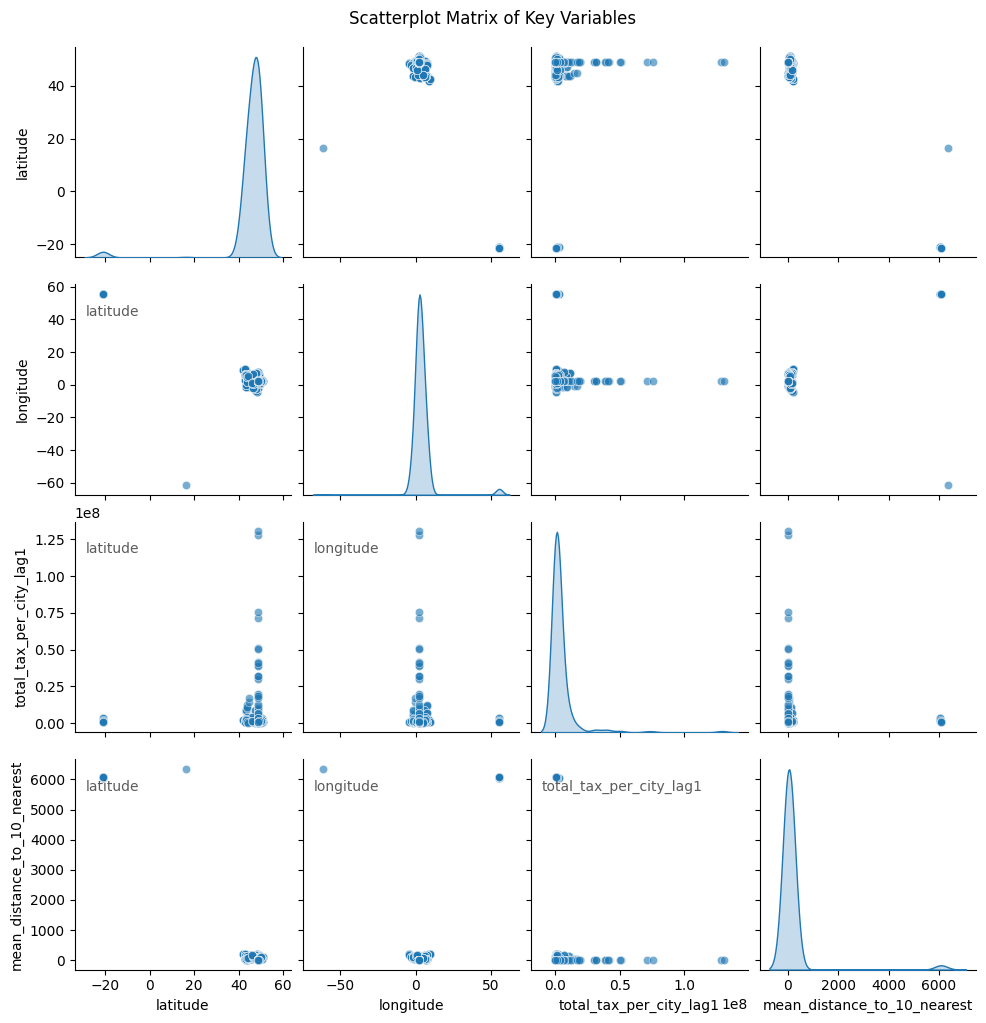

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_scatterplot_matrix(df):
    """
    Generate a scatterplot matrix for a subset of key variables from the provided DataFrame.

    Parameters:
    - df: DataFrame containing the data.

    Returns:
    - None. (Displays the scatterplot matrix)
    """

    # Define a subset of columns for visualization
    subset_cols = ['latitude', 'longitude', 'total_tax_per_city_lag1',
                    'mean_distance_to_10_nearest']
    subset = df[subset_cols]

    # Construct the scatterplot matrix
    g = sns.pairplot(subset, diag_kind='kde', plot_kws={'alpha': 0.6})

    # Annotate the plots in the lower triangle
    for i, row_axes in enumerate(g.axes):
        for j, ax in enumerate(row_axes):
            if i > j:
                ax.annotate(subset.columns[j], xy=(0.05, 0.85), xycoords='axes fraction',
                            fontsize=10, color='#333333', alpha=0.8,
                            fontname='DejaVu Sans', weight='light')

    # Display the scatterplot matrix
    plt.suptitle('Scatterplot Matrix of Key Variables', y=1.02)
    plt.show()

# Use the function
plot_scatterplot_matrix(df_ificom_clean)

# Use the function again as needed
# plot_scatterplot_matrix(another_dataframe)


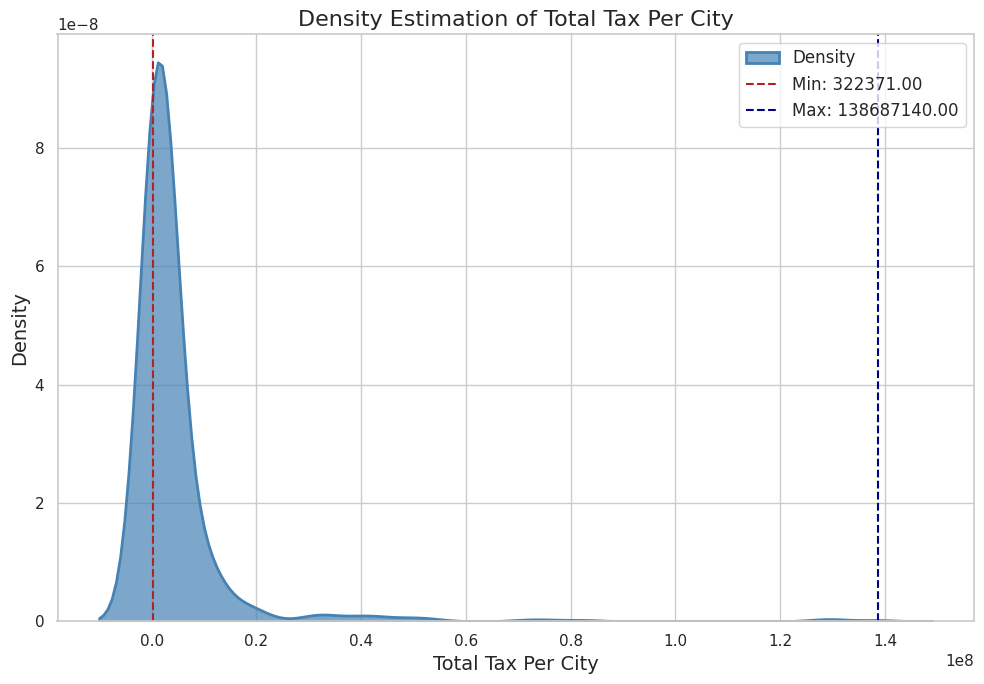

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_density_estimation(data):
    """
    Plot a KDE (Kernel Density Estimation) for the provided data.

    Parameters:
    - data: Series or List containing the data to plot.

    Returns:
    - None. (Displays the KDE plot)
    """

    # Set up Seaborn's style
    sns.set_theme(style="whitegrid")

    # Create the KDE plot
    plt.figure(figsize=(10, 7))
    sns.kdeplot(data, fill=True, color='steelblue', linewidth=2, alpha=0.7, label='Density')

    # Highlight the min and max values
    plt.axvline(min(data), color='firebrick', linestyle='--', linewidth=1.5, label=f'Min: {min(data):.2f}')
    plt.axvline(max(data), color='darkblue', linestyle='--', linewidth=1.5, label=f'Max: {max(data):.2f}')

    # Label the plot
    plt.xlabel('Total Tax Per City', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.title('Density Estimation of Total Tax Per City', fontsize=16)
    plt.legend(loc='upper right', fontsize=12)

    # Display the plot
    plt.tight_layout()
    plt.show()

# Use the function
plot_density_estimation(y)



#### Cleaning outliers


In [10]:
# Detect outliers based on IQR for 'total_tax_per_city'.
Q1 = df_ificom_clean['total_tax_per_city'].quantile(0.25)
Q3 = df_ificom_clean['total_tax_per_city'].quantile(0.75)
IQR = Q3 - Q1
lower_threshold = Q1 - 1.5 * IQR
upper_threshold = Q3 + 1.5 * IQR

# Identify unique Commune_Code_INSEE with outlier values.
outlier_communes = df_ificom_clean.loc[
    (df_ificom_clean['total_tax_per_city'] < lower_threshold) |
    (df_ificom_clean['total_tax_per_city'] > upper_threshold),
    'Commune_Code_INSEE'
].unique()

# Filter out rows corresponding to outlier communes.
df_ificom_clean = df_ificom_clean[~df_ificom_clean['Commune_Code_INSEE'].isin(outlier_communes)].copy()

# Cleaning NAN Values
for col in df_ificom_clean.columns:
    if df_ificom_clean[col].dtype in ['float64', 'int64']:
        df_ificom_clean[col] = df_ificom_clean.groupby('Commune_Code_INSEE')[col].fillna(method='ffill')



df_ificom_clean=df_ificom_clean.dropna()



In [11]:
# Calling function to prepare data
# Reset the index of the selected columns in the main DataFrame and drop the old index



# Separate features and target variable
X = df_ificom_clean[['Year', 'latitude', 'longitude', 'total_tax_per_city_lag1',
                     'mean', 'median', 'min', 'max',
                     'mean_distance_to_10_nearest']]
y = df_ificom_clean['total_tax_per_city']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1))


# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

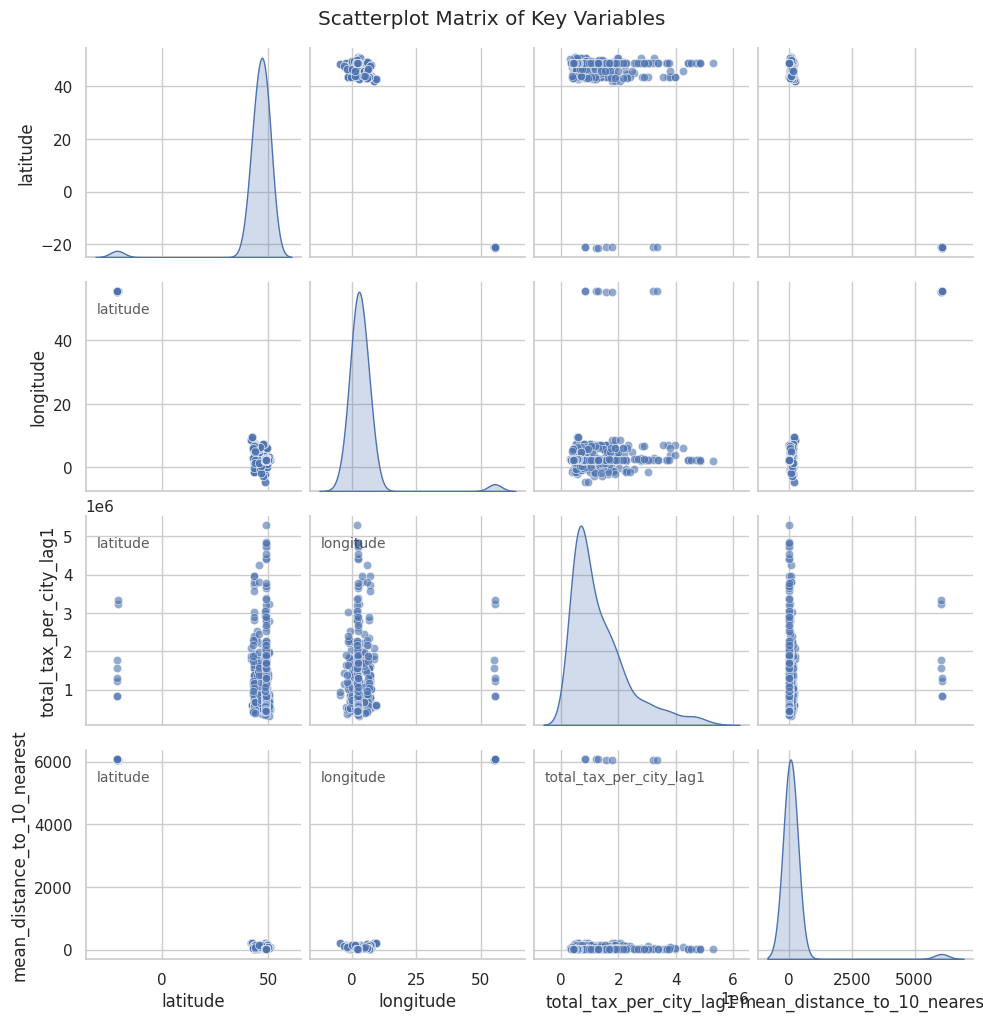

In [12]:
#Plotting ABT
plot_scatterplot_matrix(df_ificom_clean)

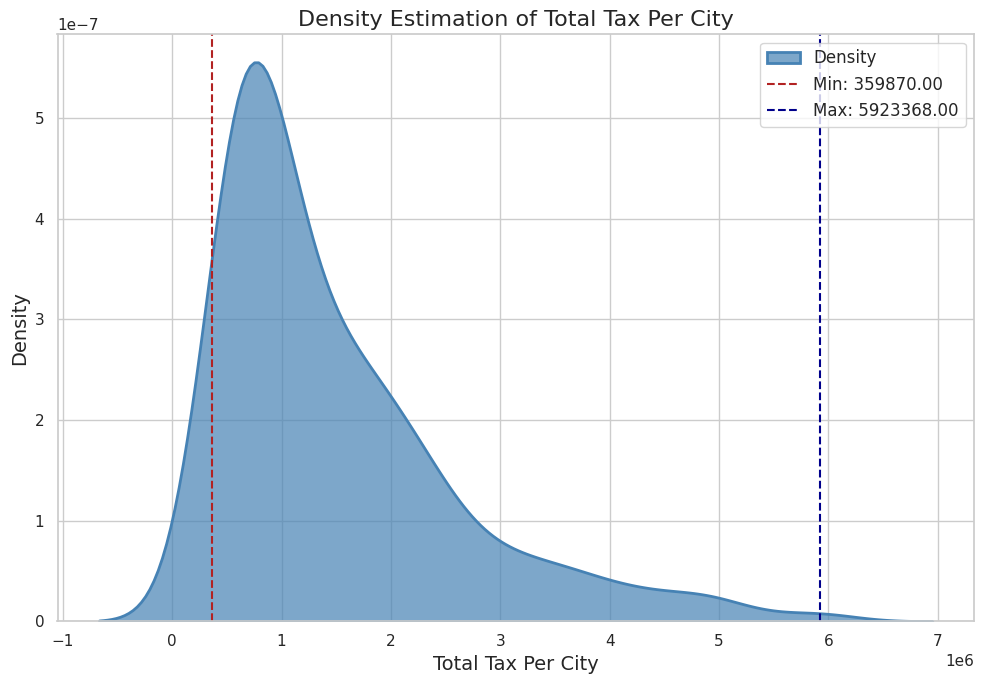

In [13]:
#PLotting Y
plot_density_estimation(y)


# Running Models to Select the Best One, with Hyperparameter Optimization

In this section, we'll embark on training various predictive models using the meticulously prepared dataset.
Starting with foundational algorithms, we'll progressively integrate more sophisticated methods, including
Neural Networks (NN) and XGBoost. Our objective is to harness the power of these advanced techniques,
fine-tuning them to attain optimal performance and pinpoint accuracy in forecasting the total tax revenue
for cities in the upcoming years.


###### MODEL: Linear Regression model

In [14]:
# Linear Regression for Tax Revenue Prediction

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, KFold
import pandas as pd
import numpy as np

# Initialize the Linear Regression model
lin_regressor = LinearRegression()

# Implement KFold cross-validation for robustness
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Define custom scoring metrics for evaluation
mse_scorer = make_scorer(mean_squared_error)
r2_scorer = make_scorer(r2_score)
mae_scorer = make_scorer(mean_absolute_error)

# Evaluate model using cross-validation
mse_scores = cross_val_score(lin_regressor, X_train, y_train, cv=kfold, scoring=mse_scorer)
r2_scores = cross_val_score(lin_regressor, X_train, y_train, cv=kfold, scoring=r2_scorer)
mae_scores = cross_val_score(lin_regressor, X_train, y_train, cv=kfold, scoring=mae_scorer)

# Train the model on the entire training dataset
lin_regressor.fit(X_train, y_train)

# Predictions on both training and testing datasets
train_predictions = lin_regressor.predict(X_train)
test_predictions = lin_regressor.predict(X_test)

# Evaluation metrics for training dataset
mse_train = mean_squared_error(y_train, train_predictions)
r2_train = r2_score(y_train, train_predictions)
mae_train = mean_absolute_error(y_train, train_predictions)

# Evaluation metrics for testing dataset
mse_test = mean_squared_error(y_test, test_predictions)
r2_test = r2_score(y_test, test_predictions)
mae_test = mean_absolute_error(y_test, test_predictions)

# Consolidate results into a structured DataFrame for clarity
evaluation_metrics = {
    'Model': ['Linear Regression'],
    'Avg_MSE_CV': [np.mean(mse_scores)],
    'Std_MSE_CV': [np.std(mse_scores)],
    'Avg_R2_CV': [np.mean(r2_scores)],
    'Std_R2_CV': [np.std(r2_scores)],
    'Avg_MAE_CV': [np.mean(mae_scores)],
    'Std_MAE_CV': [np.std(mae_scores)],
    'MSE_Train': [mse_train],
    'R2_Train': [r2_train],
    'MAE_Train': [mae_train],
    'MSE_Test': [mse_test],
    'R2_Test': [r2_test],
    'MAE_Test': [mae_test]
}

results_df = pd.DataFrame(evaluation_metrics)
results_df

,Model,Avg_MSE_CV,Std_MSE_CV,Avg_R2_CV,Std_R2_CV,Avg_MAE_CV,Std_MAE_CV,MSE_Train,R2_Train,MAE_Train,MSE_Test,R2_Test,MAE_Test
0,Linear Regression,3.396769e+10,3.488303e+10,0.96569,0.03613,108121.379692,40052.207152,2.681235e+10,0.977972,99475.826118,1.976297e+10,0.981928,97295.236877


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Set Seaborn style and context
sns.set_style("darkgrid")
sns.set_context("talk")

def plot_residuals_vs_predicted(test_predictions, residuals_test):
    """
    Plot residuals vs predicted values.
    """
    plt.scatter(test_predictions, residuals_test, color=colors[0], alpha=0.7, s=60)
    plt.hlines(0, test_predictions.min(), test_predictions.max(), colors='grey', linestyles='dashed')
    plt.title('Residuals vs. Predicted Values', fontsize=15)
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

def plot_feature_coefficients(coefficients, columns):
    """
    Plot feature coefficients.
    """
    sorted_idx = np.argsort(np.abs(coefficients))
    plt.barh(np.array(columns)[sorted_idx], coefficients[sorted_idx], color=colors[1], alpha=0.7)
    plt.xlabel('Coefficient Magnitude')
    plt.title('Feature Coefficients', fontsize=15)
    plt.tick_params(axis='y', labelsize=10)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)


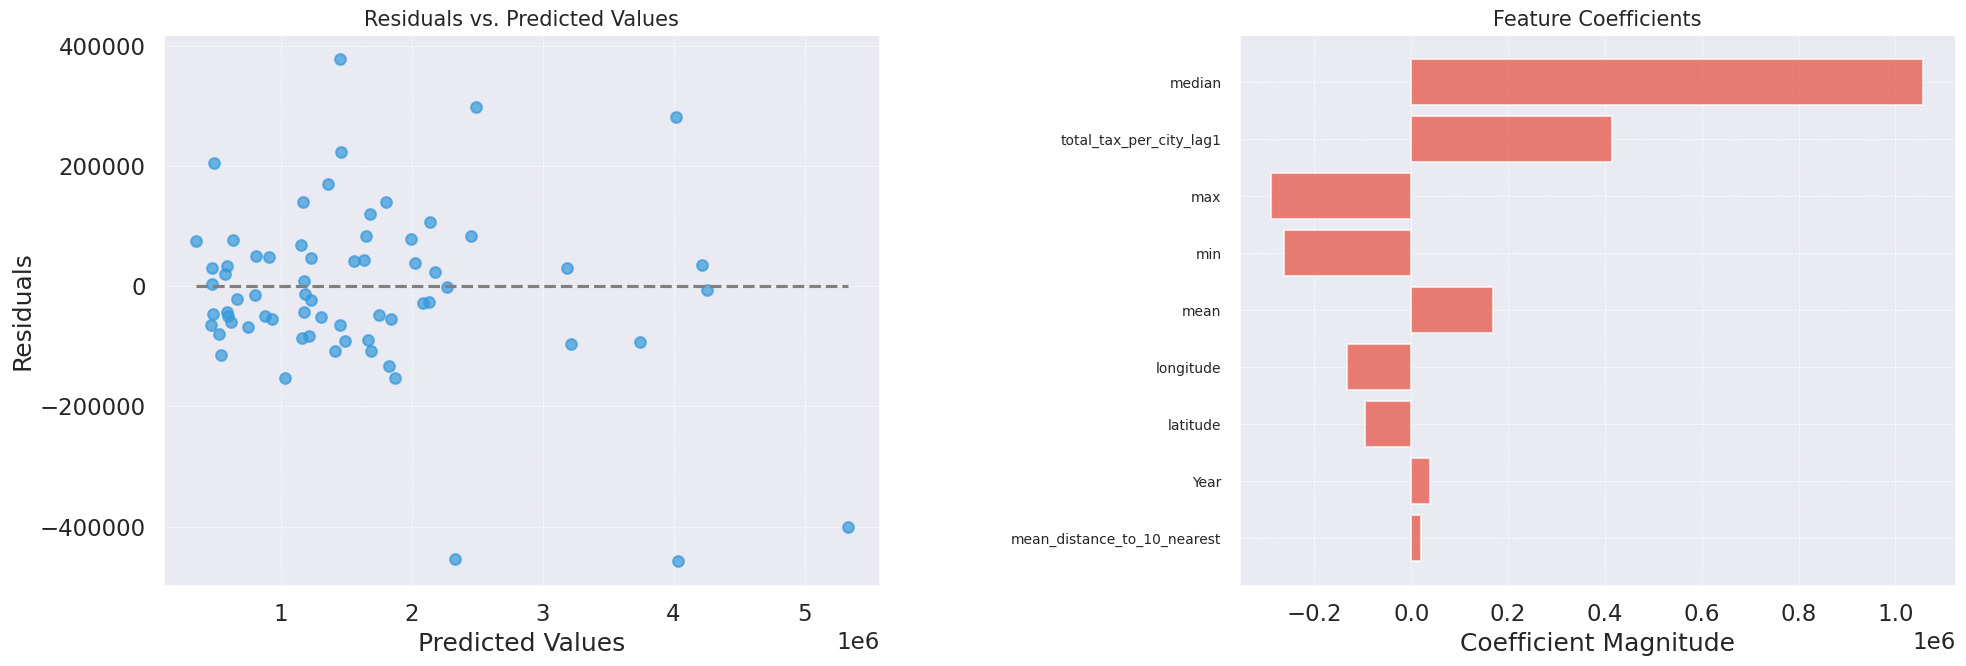

In [16]:
# Define colors for plots
colors = ["#3498db", "#e74c3c"]

# Calculate residuals
residuals_test = y_test - test_predictions

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

plt.sca(ax[0])
plot_residuals_vs_predicted(test_predictions, residuals_test)

plt.sca(ax[1])
plot_feature_coefficients(lin_regressor.coef_, X.columns)

# Adjust layout and show plots
plt.tight_layout()
plt.subplots_adjust(wspace=0.5)
plt.show()


###### MODEL: Decision tree (Adjusted)

In [17]:
#Decision tree (Adjusted

import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, KFold

# Initialize the decision tree regressor
tree_regressor = DecisionTreeRegressor(max_depth=5, min_samples_split=10, min_samples_leaf=5)

# Configure KFold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Define scorers for evaluation
scorers = {
    'MSE': make_scorer(mean_squared_error),
    'R2': make_scorer(r2_score),
    'MAE': make_scorer(mean_absolute_error)
}

# Compute cross-validation scores
cv_scores = {metric: cross_val_score(tree_regressor, X_train, y_train, cv=kfold, scoring=scorer)
             for metric, scorer in scorers.items()}

# Train the model and make predictions
tree_regressor.fit(X_train, y_train)
y_pred_train = tree_regressor.predict(X_train)
y_pred_test = tree_regressor.predict(X_test)

# Calculate evaluation metrics for training data
train_scores = {
    'MSE_Train': mean_squared_error(y_train, y_pred_train),
    'R2_Train': r2_score(y_train, y_pred_train),
    'MAE_Train': mean_absolute_error(y_train, y_pred_train)
}

# Calculate evaluation metrics for test data
test_scores = {
    'MSE_Test': mean_squared_error(y_test, y_pred_test),
    'R2_Test': r2_score(y_test, y_pred_test),
    'MAE_Test': mean_absolute_error(y_test, y_pred_test)
}

# Compile results into a DataFrame
evaluation_metrics = {
    'Model': ['Decision Tree (Adjusted)'],
    'Avg_MSE_CV': [cv_scores['MSE'].mean()],
    'Std_MSE_CV': [cv_scores['MSE'].std()],
    'Avg_R2_CV': [cv_scores['R2'].mean()],
    'Std_R2_CV': [cv_scores['R2'].std()],
    'Avg_MAE_CV': [cv_scores['MAE'].mean()],
    'Std_MAE_CV': [cv_scores['MAE'].std()],
    **train_scores,
    **test_scores
}

tree_results_df = pd.DataFrame(evaluation_metrics)

# Add results to the existing DataFrame (assuming results_df exists)
results_df = pd.concat([results_df, tree_results_df], ignore_index=True)
results_df

,Model,Avg_MSE_CV,Std_MSE_CV,Avg_R2_CV,Std_R2_CV,Avg_MAE_CV,Std_MAE_CV,MSE_Train,R2_Train,MAE_Train,MSE_Test,R2_Test,MAE_Test
0,Linear Regression,3.396769e+10,3.488303e+10,0.96569,0.036130,108121.379692,40052.207152,2.681235e+10,0.977972,99475.826118,1.976297e+10,0.981928,97295.236877
1,Decision Tree (Adjusted),4.599743e+10,2.370902e+10,0.95180,0.032455,135264.444516,42191.764484,2.225299e+10,0.981718,88294.733716,2.944407e+10,0.973075,127826.280935


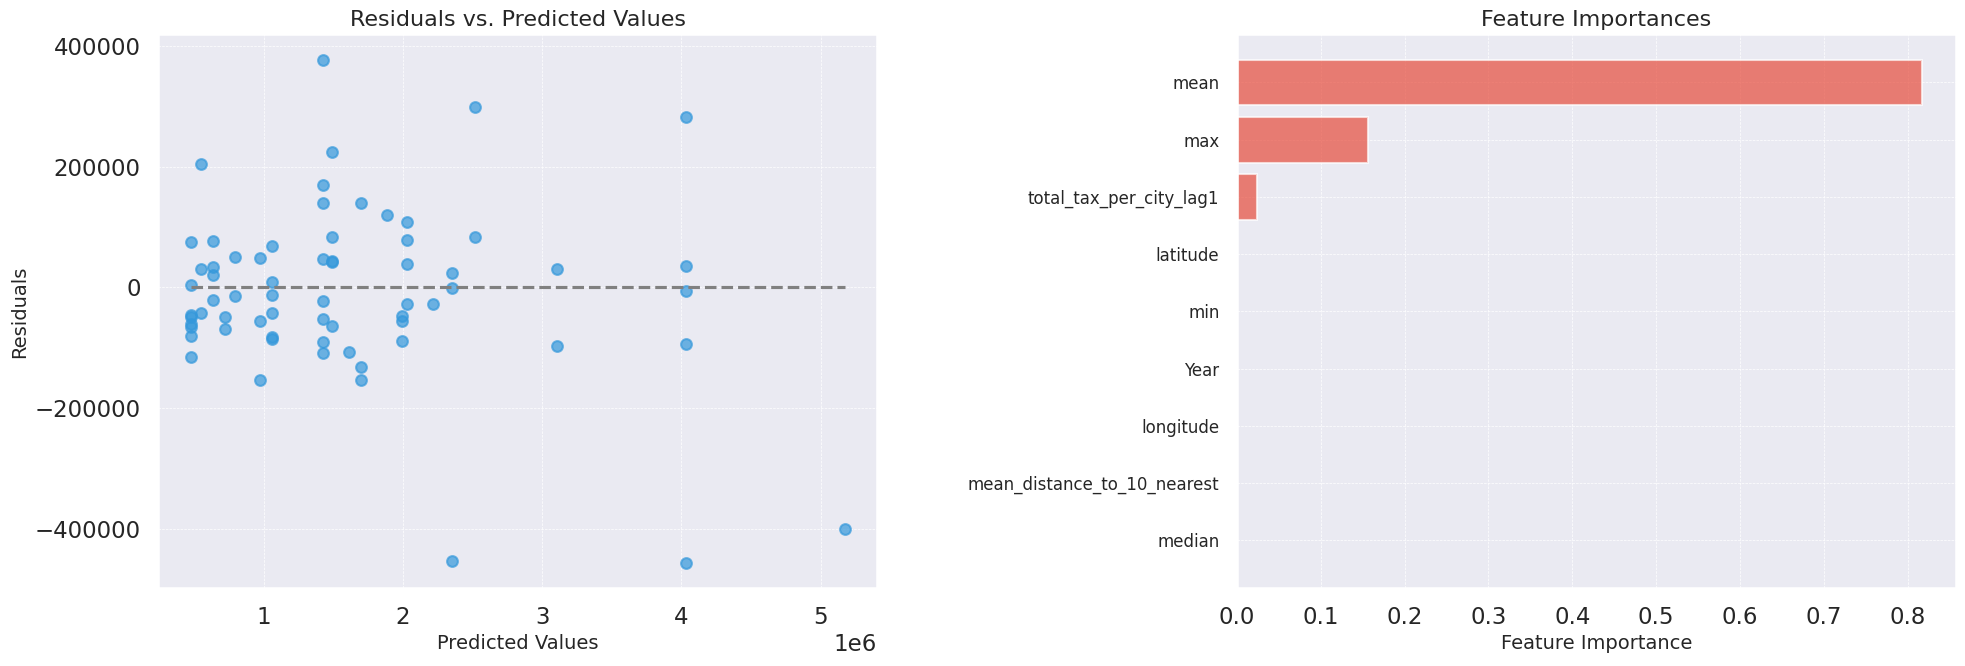

In [18]:
# Setting up the visualization style
sns.set_style("darkgrid")
color_palette = ["#3498db", "#e74c3c"]

# Initializing the subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# Residuals vs. Predicted Values
axes[0].scatter(y_pred_test, residuals_test, color=color_palette[0], alpha=0.7, s=60)
axes[0].hlines(0, y_pred_test.min(), y_pred_test.max(), colors='grey', linestyles='dashed')
axes[0].set_title('Residuals vs. Predicted Values', fontsize=16)
axes[0].set_xlabel('Predicted Values', fontsize=14)
axes[0].set_ylabel('Residuals', fontsize=14)
axes[0].grid(True, which='both', linestyle='--', linewidth=0.5)

# Feature Importances
feature_importances = tree_regressor.feature_importances_

sorted_indices = np.argsort(feature_importances)
axes[1].barh(np.array(X.columns)[sorted_indices], feature_importances[sorted_indices], color=color_palette[1], alpha=0.7)
axes[1].set_title('Feature Importances', fontsize=16)
axes[1].set_xlabel('Feature Importance', fontsize=14)
axes[1].tick_params(axis='y', labelsize=12)
axes[1].grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjusting layout for proper visualization
plt.tight_layout()
plt.subplots_adjust(wspace=0.5)
plt.show()


###### MODEL: Decision Tree (Grid Search)

In [19]:
#Decision Tree (Grid Search)
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
import pandas as pd
import numpy as np

# Define hyperparameter space
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10]
}

# Create the base model
tree_regressor = DecisionTreeRegressor()

# Using the same KFold cross-validation settings from before
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(tree_regressor, param_grid, cv=kfold, scoring='neg_mean_squared_error')

# Train GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best model
best_tree = grid_search.best_estimator_

# Predict on train and test data
y_pred_train_best_tree = best_tree.predict(X_train)
y_pred_test_best_tree = best_tree.predict(X_test)

# Cross-validation scores for Decision Tree using best_tree
mse_scores_best_tree = cross_val_score(best_tree, X_train, y_train, cv=kfold, scoring=mse_scorer)
r2_scores_best_tree = cross_val_score(best_tree, X_train, y_train, cv=kfold, scoring=r2_scorer)
mae_scores_best_tree = cross_val_score(best_tree, X_train, y_train, cv=kfold, scoring=mae_scorer)

# Calculate metrics on train data
mse_train_best_tree = mean_squared_error(y_train, y_pred_train_best_tree)
r2_train_best_tree = r2_score(y_train, y_pred_train_best_tree)
mae_train_best_tree = mean_absolute_error(y_train, y_pred_train_best_tree)

# Calculate metrics on test data
mse_test_best_tree = mean_squared_error(y_test, y_pred_test_best_tree)
r2_test_best_tree = r2_score(y_test, y_pred_test_best_tree)
mae_test_best_tree = mean_absolute_error(y_test, y_pred_test_best_tree)

# Compile results into a DataFrame for Decision Tree with Grid Search
evaluation_metrics_tree = {
    'Model': ['Decision Tree (Grid Search)'],
    'Avg_MSE_CV': [np.mean(mse_scores_best_tree)],
    'Std_MSE_CV': [np.std(mse_scores_best_tree)],
    'Avg_R2_CV': [np.mean(r2_scores_best_tree)],
    'Std_R2_CV': [np.std(r2_scores_best_tree)],
    'Avg_MAE_CV': [np.mean(mae_scores_best_tree)],
    'Std_MAE_CV': [np.std(mae_scores_best_tree)],
    'MSE_Train': [mse_train_best_tree],
    'R2_Train': [r2_train_best_tree],
    'MAE_Train': [mae_train_best_tree],
    'MSE_Test': [mse_test_best_tree],
    'R2_Test': [r2_test_best_tree],
    'MAE_Test': [mae_test_best_tree]
}

tree_results_df = pd.DataFrame(evaluation_metrics_tree)

# Append results to the existing DataFrame
results_df = pd.concat([results_df, tree_results_df], ignore_index=True)
results_df


,Model,Avg_MSE_CV,Std_MSE_CV,Avg_R2_CV,Std_R2_CV,Avg_MAE_CV,Std_MAE_CV,MSE_Train,R2_Train,MAE_Train,MSE_Test,R2_Test,MAE_Test
0,Linear Regression,3.396769e+10,3.488303e+10,0.965690,0.036130,108121.379692,40052.207152,2.681235e+10,0.977972,99475.826118,1.976297e+10,0.981928,97295.236877
1,Decision Tree (Adjusted),4.599743e+10,2.370902e+10,0.951800,0.032455,135264.444516,42191.764484,2.225299e+10,0.981718,88294.733716,2.944407e+10,0.973075,127826.280935
2,Decision Tree (Grid Search),4.153564e+10,1.419011e+10,0.952009,0.029078,125732.647132,26087.765292,1.290613e+10,0.989397,76632.178770,3.640696e+10,0.966708,128489.895592


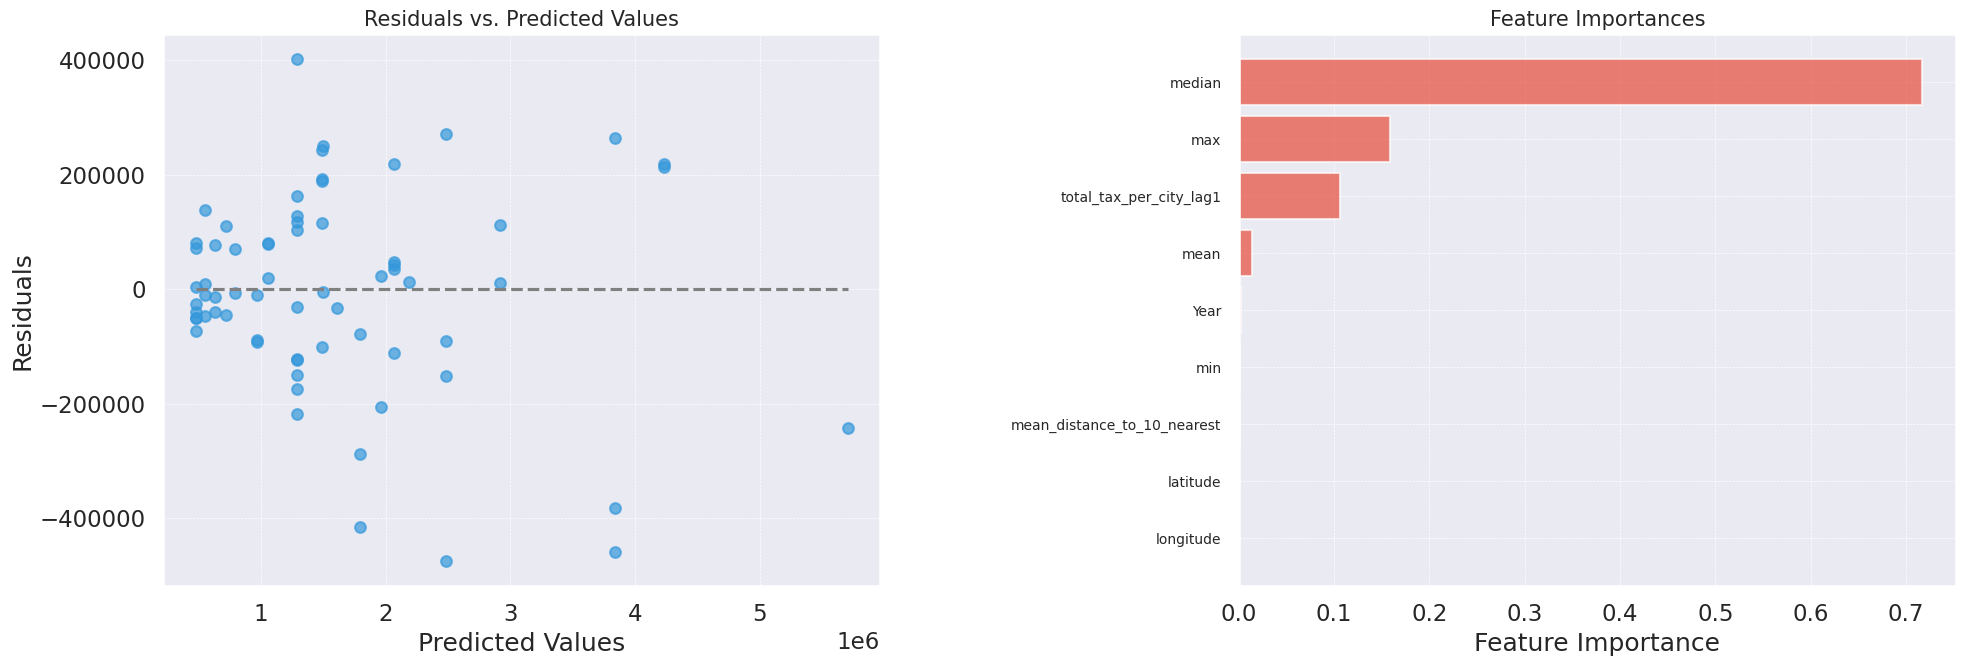

In [20]:
best_tree.fit(X_train, y_train)
y_pred = best_tree.predict(X_test)

sns.set_style("darkgrid")
colors = ["#3498db", "#e74c3c"]

# Extract feature importances and calculate residuals
feature_importances = best_tree.feature_importances_
residuals_test = y_test - y_pred_test

# Create plots
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

# Plot residuals
ax[0].scatter(y_pred, residuals_test, color=colors[0], alpha=0.7, s=60)
ax[0].hlines(0, y_pred.min(), y_pred.max(), colors='grey', linestyles='dashed')
ax[0].set_title('Residuals vs. Predicted Values', fontsize=15)
ax[0].set_xlabel('Predicted Values')
ax[0].set_ylabel('Residuals')
ax[0].grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot feature importances
sorted_idx = np.argsort(feature_importances)
ax[1].barh(np.array(X.columns)[sorted_idx], feature_importances[sorted_idx], color=colors[1], alpha=0.7)
ax[1].set_xlabel('Feature Importance')
ax[1].set_title('Feature Importances', fontsize=15)
ax[1].tick_params(axis='y', labelsize=10)
ax[1].grid(True, which='both', linestyle='--', linewidth=0.5)

# Final adjustments
plt.tight_layout()
plt.subplots_adjust(wspace=0.5)
plt.show()


###### MODEL: Random Forest

In [21]:
# Random Forest Implementation:
from sklearn.ensemble import RandomForestRegressor

# Define the hyperparameter space
param_grid_rf = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10]
}

# Initialize the base Random Forest model
rf_regressor = RandomForestRegressor()

# Use the previously defined KFold cross-validation settings
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Set up GridSearchCV for Random Forest
grid_search_rf = GridSearchCV(rf_regressor, param_grid_rf, cv=kfold, scoring='neg_mean_squared_error')

# Train the model with GridSearchCV
grid_search_rf.fit(X_train, y_train)

# Retrieve the best model from GridSearch results
best_rf = grid_search_rf.best_estimator_

# Make predictions on both train and test datasets
y_pred_train_best_rf = best_rf.predict(X_train)
y_pred_test_best_rf = best_rf.predict(X_test)

# Define custom scoring functions (as done previously)
mse_scorer = make_scorer(mean_squared_error)
r2_scorer = make_scorer(r2_score)
mae_scorer = make_scorer(mean_absolute_error)

# Obtain cross-validation scores for Random Forest using the best parameters
mse_scores_rf = cross_val_score(best_rf, X_train, y_train, cv=kfold, scoring=mse_scorer)
r2_scores_rf = cross_val_score(best_rf, X_train, y_train, cv=kfold, scoring=r2_scorer)
mae_scores_rf = cross_val_score(best_rf, X_train, y_train, cv=kfold, scoring=mae_scorer)

# Calculate performance metrics on the training set
mse_train_best_rf = mean_squared_error(y_train, y_pred_train_best_rf)
r2_train_best_rf = r2_score(y_train, y_pred_train_best_rf)
mae_train_best_rf = mean_absolute_error(y_train, y_pred_train_best_rf)

# Calculate performance metrics on the test set
mse_test_best_rf = mean_squared_error(y_test, y_pred_test_best_rf)
r2_test_best_rf = r2_score(y_test, y_pred_test_best_rf)
mae_test_best_rf = mean_absolute_error(y_test, y_pred_test_best_rf)

# Organize results into a DataFrame for Random Forest with Grid Search optimization
evaluation_metrics_rf = {
    'Model': ['Random Forest (Grid Search)'],
    'Avg_MSE_CV': [np.mean(mse_scores_rf)],
    'Std_MSE_CV': [np.std(mse_scores_rf)],
    'Avg_R2_CV': [np.mean(r2_scores_rf)],
    'Std_R2_CV': [np.std(r2_scores_rf)],
    'Avg_MAE_CV': [np.mean(mae_scores_rf)],
    'Std_MAE_CV': [np.std(mae_scores_rf)],
    'MSE_Train': [mse_train_best_rf],
    'R2_Train': [r2_train_best_rf],
    'MAE_Train': [mae_train_best_rf],
    'MSE_Test': [mse_test_best_rf],
    'R2_Test': [r2_test_best_rf],
    'MAE_Test': [mae_test_best_rf]
}

rf_results_df = pd.DataFrame(evaluation_metrics_rf)

# Append the Random Forest results to the main results DataFrame
results_df = pd.concat([results_df, rf_results_df], ignore_index=True)
results_df

,Model,Avg_MSE_CV,Std_MSE_CV,Avg_R2_CV,Std_R2_CV,Avg_MAE_CV,Std_MAE_CV,MSE_Train,R2_Train,MAE_Train,MSE_Test,R2_Test,MAE_Test
0,Linear Regression,3.396769e+10,3.488303e+10,0.965690,0.036130,108121.379692,40052.207152,2.681235e+10,0.977972,99475.826118,1.976297e+10,0.981928,97295.236877
1,Decision Tree (Adjusted),4.599743e+10,2.370902e+10,0.951800,0.032455,135264.444516,42191.764484,2.225299e+10,0.981718,88294.733716,2.944407e+10,0.973075,127826.280935
2,Decision Tree (Grid Search),4.153564e+10,1.419011e+10,0.952009,0.029078,125732.647132,26087.765292,1.290613e+10,0.989397,76632.178770,3.640696e+10,0.966708,128489.895592
3,Random Forest (Grid Search),3.467819e+10,2.615683e+10,0.964818,0.030461,115693.484900,34571.647542,9.754423e+09,0.991986,59379.894739,2.745628e+10,0.974893,119176.672555


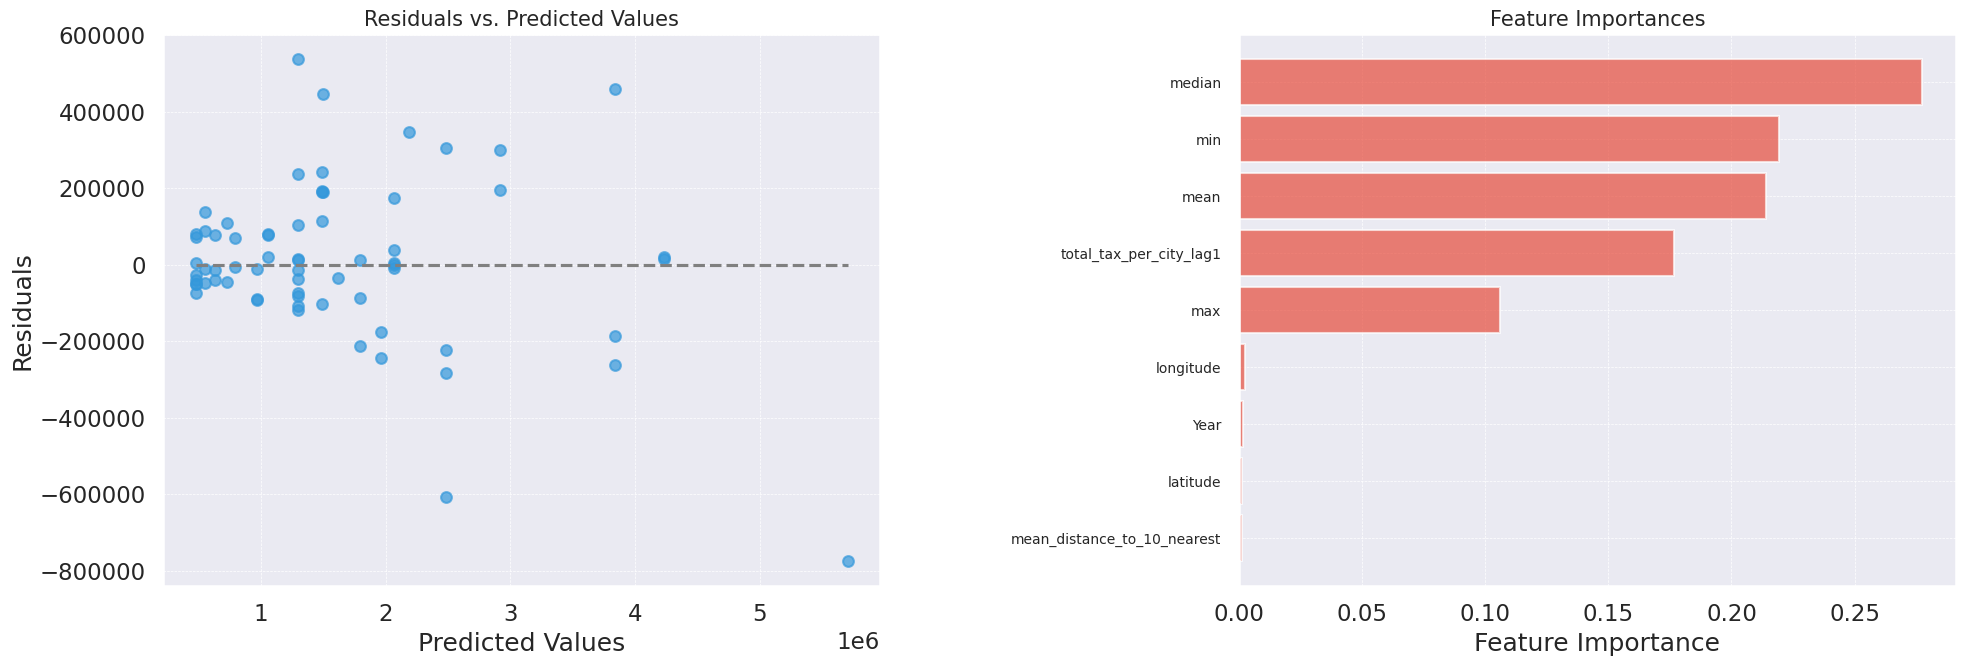

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set Seaborn style
sns.set_style("darkgrid")
colors = ["#3498db", "#e74c3c"]

# Extract feature importances and calculate residuals for Random Forest
feature_importances_rf = best_rf.feature_importances_
residuals_rf = y_test - y_pred

# Create plots
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

# Plot residuals
ax[0].scatter(y_pred, residuals_rf, color=colors[0], alpha=0.7, s=60)
ax[0].hlines(0, y_pred.min(), y_pred.max(), colors='grey', linestyles='dashed')
ax[0].set_title('Residuals vs. Predicted Values', fontsize=15)
ax[0].set_xlabel('Predicted Values')
ax[0].set_ylabel('Residuals')
ax[0].grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot feature importances
sorted_idx_rf = np.argsort(feature_importances_rf)
ax[1].barh(np.array(X.columns)[sorted_idx_rf], feature_importances_rf[sorted_idx_rf], color=colors[1], alpha=0.7)
ax[1].set_xlabel('Feature Importance')
ax[1].set_title('Feature Importances', fontsize=15)
ax[1].tick_params(axis='y', labelsize=10)
ax[1].grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(wspace=0.5)
plt.show()


###### MODEL: Xgboost

In [23]:
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV, KFold

# Define hyperparameter space for XGBoost
param_grid_xgb = {
    'n_estimators': [10, 50, 100, 200,250,300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'subsample': [0.5, 0.7, 0.9, 1.0],
    'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.25, 0.5, 1.0],
    #'tree_method': ['gpu_hist'],  # Use GPU optimized method
}

# Initialize base XGBoost model
xgb_regressor = xgb.XGBRegressor()

# Set up KFold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Configure GridSearchCV for XGBoost
grid_search_xgb = GridSearchCV(xgb_regressor, param_grid_xgb, cv=kfold, scoring='neg_mean_squared_error')

# Train GridSearchCV with XGBoost
grid_search_xgb.fit(X_train, y_train)

# Extract the optimal XGBoost model
best_xgb = grid_search_xgb.best_estimator_

# Predict using the optimal model
y_pred_train_best_xgb = best_xgb.predict(X_train)
y_pred_test_best_xgb = best_xgb.predict(X_test)

# Cross-validation scores for XGBoost using best_xgb
mse_scores_xgb = cross_val_score(best_xgb, X_train, y_train, cv=kfold, scoring=mse_scorer)
r2_scores_xgb = cross_val_score(best_xgb, X_train, y_train, cv=kfold, scoring=r2_scorer)
mae_scores_xgb = cross_val_score(best_xgb, X_train, y_train, cv=kfold, scoring=mae_scorer)

# Compile results into a DataFrame for XGBoost with Grid Search
evaluation_metrics_xgb = {
    'Model': ['XGBoost (Grid Search)'],
    'Avg_MSE_CV': [np.mean(mse_scores_xgb)],
    'Std_MSE_CV': [np.std(mse_scores_xgb)],
    'Avg_R2_CV': [np.mean(r2_scores_xgb)],
    'Std_R2_CV': [np.std(r2_scores_xgb)],
    'Avg_MAE_CV': [np.mean(mae_scores_xgb)],
    'Std_MAE_CV': [np.std(mae_scores_xgb)],
    'MSE_Train': [mean_squared_error(y_train, y_pred_train_best_xgb)],
    'R2_Train': [r2_score(y_train, y_pred_train_best_xgb)],
    'MAE_Train': [mean_absolute_error(y_train, y_pred_train_best_xgb)],
    'MSE_Test': [mean_squared_error(y_test, y_pred_test_best_xgb)],
    'R2_Test': [r2_score(y_test, y_pred_test_best_xgb)],
    'MAE_Test': [mean_absolute_error(y_test, y_pred_test_best_xgb)]
}

xgb_results_df = pd.DataFrame(evaluation_metrics_xgb)

# Append results to the existing DataFrame
results_df = pd.concat([results_df, xgb_results_df], ignore_index=True)
results_df

,Model,Avg_MSE_CV,Std_MSE_CV,Avg_R2_CV,Std_R2_CV,Avg_MAE_CV,Std_MAE_CV,MSE_Train,R2_Train,MAE_Train,MSE_Test,R2_Test,MAE_Test
0,Linear Regression,3.396769e+10,3.488303e+10,0.965690,0.036130,108121.379692,40052.207152,2.681235e+10,0.977972,99475.826118,1.976297e+10,0.981928,97295.236877
1,Decision Tree (Adjusted),4.599743e+10,2.370902e+10,0.951800,0.032455,135264.444516,42191.764484,2.225299e+10,0.981718,88294.733716,2.944407e+10,0.973075,127826.280935
2,Decision Tree (Grid Search),4.153564e+10,1.419011e+10,0.952009,0.029078,125732.647132,26087.765292,1.290613e+10,0.989397,76632.178770,3.640696e+10,0.966708,128489.895592
3,Random Forest (Grid Search),3.467819e+10,2.615683e+10,0.964818,0.030461,115693.484900,34571.647542,9.754423e+09,0.991986,59379.894739,2.745628e+10,0.974893,119176.672555
4,XGBoost (Grid Search),2.959361e+10,2.218329e+10,0.968016,0.033418,108269.832350,31976.810590,6.438436e+09,0.994711,56955.089286,3.350540e+10,0.969361,118415.753265


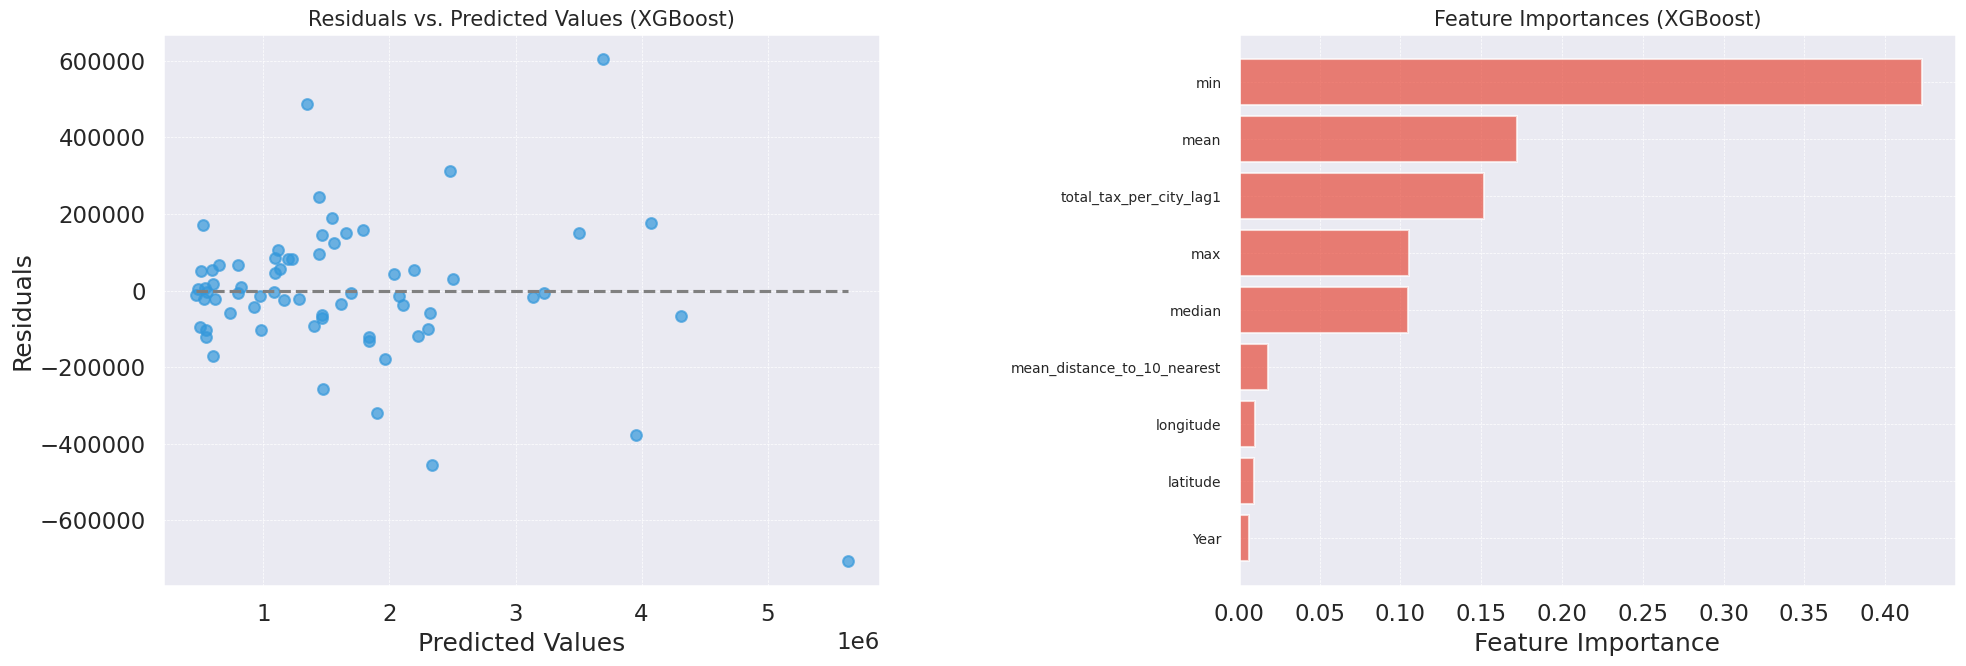

In [24]:

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set professional dark style with Seaborn
sns.set_style("darkgrid")
colors = ["#3498db", "#e74c3c"]

# Extract feature importances and calculate residuals
feature_importances_xgb = best_xgb.feature_importances_
residuals_xgb = y_test - y_pred_test_best_xgb

# Create plots
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

# Plot residuals
ax[0].scatter(y_pred_test_best_xgb, residuals_xgb, color=colors[0], alpha=0.7, s=60)
ax[0].hlines(0, y_pred_test_best_xgb.min(), y_pred_test_best_xgb.max(), colors='grey', linestyles='dashed')
ax[0].set_title('Residuals vs. Predicted Values (XGBoost)', fontsize=15)
ax[0].set_xlabel('Predicted Values')
ax[0].set_ylabel('Residuals')
ax[0].grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot feature importances
sorted_idx_xgb = np.argsort(feature_importances_xgb)
ax[1].barh(np.array(X.columns)[sorted_idx_xgb], feature_importances_xgb[sorted_idx_xgb], color=colors[1], alpha=0.7)
ax[1].set_xlabel('Feature Importance')
ax[1].set_title('Feature Importances (XGBoost)', fontsize=15)
ax[1].tick_params(axis='y', labelsize=10)
ax[1].grid(True, which='both', linestyle='--', linewidth=0.5)

# Final adjustments
plt.tight_layout()
plt.subplots_adjust(wspace=0.5)
plt.show()


###### MODEL: NN Model

In [25]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 46.4 MB/s eta 0:00:00


In [26]:
# Neural Network (NN) model
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import pandas as pd
from keras_tuner import HyperModel, RandomSearch

# Definition of the HyperModel for the neural network model
class NNHyperModel(HyperModel):
    def __init__(self, input_dim):
        self.input_dim = input_dim

    def build(self, hp):
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Dense(units=hp.Int('units_input', min_value=32, max_value=256, step=32),
                                        activation='relu', input_dim=self.input_dim))
        for i in range(hp.Int('n_layers', 1, 5)):
            model.add(tf.keras.layers.Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32),
                                            activation='relu'))
        model.add(tf.keras.layers.Dense(1))
        optimizer = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])
        model.compile(optimizer=optimizer, loss='mean_squared_error')
        return model

# Check the type of X_train and y_train, and reset indices if they are pandas objects
if isinstance(X_train, pd.DataFrame) or isinstance(X_train, pd.Series):
    X_train = X_train.reset_index(drop=True)
if isinstance(y_train, pd.DataFrame) or isinstance(y_train, pd.Series):
    y_train = y_train.reset_index(drop=True)

hypermodel = NNHyperModel(input_dim=X_train.shape[1])
tuner = RandomSearch(hypermodel, objective='val_loss', max_trials=30, executions_per_trial=2,
                      directory='nn_hyperopt', project_name='NN_tuning')

tuner.search(X_train, y_train, epochs=50, validation_split=0.2, verbose=0,
              callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose=1,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])

# Evaluation using cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

mse_scores_nn = []
r2_scores_nn = []
mae_scores_nn = []

for train, val in kfold.split(X_train, y_train):
    model = tuner.hypermodel.build(best_hps)
    model.fit(X_train[train], y_train[train], epochs=100, validation_data=(X_train[val], y_train[val]), verbose=1,
              callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])
    y_pred_val = model.predict(X_train[val]).flatten()
    mse_scores_nn.append(mean_squared_error(y_train[val], y_pred_val))
    r2_scores_nn.append(r2_score(y_train[val], y_pred_val))
    mae_scores_nn.append(mean_absolute_error(y_train[val], y_pred_val))

# Final predictions on train and test data
y_pred_train_nn = model.predict(X_train).flatten()
y_pred_nn = model.predict(X_test).flatten()

# Final metrics
mse_train_nn = mean_squared_error(y_train, y_pred_train_nn)
r2_train_nn = r2_score(y_train, y_pred_train_nn)
mae_train_nn = mean_absolute_error(y_train, y_pred_train_nn)

mse_nn = mean_squared_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)
mae_nn = mean_absolute_error(y_test, y_pred_nn)

# Compilation of results
evaluation_metrics_nn = {
    'Model': ['Optimized Neural Network'],
    'Avg_MSE_CV': [np.mean(mse_scores_nn)],
    'Std_MSE_CV': [np.std(mse_scores_nn)],
    'Avg_R2_CV': [np.mean(r2_scores_nn)],
    'Std_R2_CV': [np.std(r2_scores_nn)],
    'Avg_MAE_CV': [np.mean(mae_scores_nn)],
    'Std_MAE_CV': [np.std(mae_scores_nn)],
    'MSE_Train': [mse_train_nn],
    'R2_Train': [r2_train_nn],
    'MAE_Train': [mae_train_nn],
    'MSE_Test': [mse_nn],
    'R2_Test': [r2_nn],
    'MAE_Test': [mae_nn]
}

nn_results_df = pd.DataFrame(evaluation_metrics_nn)
results_df = pd.concat([results_df, nn_results_df], ignore_index=True)
results_df


Using TensorFlow backend


/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/metrics_tracking.py:111: RuntimeWarning: All-NaN axis encountered
  np.nanmin(values) if self.direction == "min" else np.nanmax(values)


Epoch 1/100
7/7 [==============================] - 2s 28ms/step - loss: 3639747280896.0000 - val_loss: 2170089504768.0000
Epoch 2/100
7/7 [==============================] - 0s 7ms/step - loss: 3638808281088.0000 - val_loss: 2167624695808.0000
Epoch 3/100
7/7 [==============================] - 0s 7ms/step - loss: 3629127041024.0000 - val_loss: 2151973519360.0000
Epoch 4/100
7/7 [==============================] - 0s 7ms/step - loss: 3592632401920.0000 - val_loss: 2109982375936.0000
Epoch 5/100
7/7 [==============================] - 0s 7ms/step - loss: 3480980029440.0000 - val_loss: 1983987974144.0000
Epoch 6/100
7/7 [==============================] - 0s 9ms/step - loss: 3226494042112.0000 - val_loss: 1757160800256.0000
Epoch 7/100
7/7 [==============================] - 0s 7ms/step - loss: 2774857154560.0000 - val_loss: 1387901091840.0000
Epoch 8/100
7/7 [==============================] - 0s 7ms/step - loss: 2080971816960.0000 - val_loss: 904835366912.0000
Epoch 9/100
7/7 [===============

1/1 [==============================] - 0s 76ms/step
Epoch 1/100
8/8 [==============================] - 2s 24ms/step - loss: 3466905518080.0000 - val_loss: 2230612393984.0000
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 3465828106240.0000 - val_loss: 2228237107200.0000
Epoch 3/100
8/8 [==============================] - 0s 7ms/step - loss: 3455555207168.0000 - val_loss: 2213114544128.0000
Epoch 4/100
8/8 [==============================] - 0s 6ms/step - loss: 3407576039424.0000 - val_loss: 2167369891840.0000
Epoch 5/100
8/8 [==============================] - 0s 6ms/step - loss: 3278696873984.0000 - val_loss: 2056308916224.0000
Epoch 6/100
8/8 [==============================] - 0s 6ms/step - loss: 3004364750848.0000 - val_loss: 1849621741568.0000
Epoch 7/100
8/8 [==============================] - 0s 6ms/step - loss: 2528042024960.0000 - val_loss: 1522468913152.0000
Epoch 8/100
8/8 [==============================] - 0s 6ms/step - loss: 1826300362752.0000 - val_loss

1/1 [==============================] - 0s 72ms/step
Epoch 1/100
8/8 [==============================] - 2s 24ms/step - loss: 3226161381376.0000 - val_loss: 4405071446016.0000
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 3225015287808.0000 - val_loss: 4400032514048.0000
Epoch 3/100
8/8 [==============================] - 0s 6ms/step - loss: 3214570684416.0000 - val_loss: 4369415143424.0000
Epoch 4/100
8/8 [==============================] - 0s 6ms/step - loss: 3165899718656.0000 - val_loss: 4256996261888.0000
Epoch 5/100
8/8 [==============================] - 0s 6ms/step - loss: 3028486193152.0000 - val_loss: 4005229494272.0000
Epoch 6/100
8/8 [==============================] - 0s 6ms/step - loss: 2761396846592.0000 - val_loss: 3488390316032.0000
Epoch 7/100
8/8 [==============================] - 0s 6ms/step - loss: 2299380367360.0000 - val_loss: 2782344773632.0000
Epoch 8/100
8/8 [==============================] - 0s 6ms/step - loss: 1667186688000.0000 - val_loss

,Model,Avg_MSE_CV,Std_MSE_CV,Avg_R2_CV,Std_R2_CV,Avg_MAE_CV,Std_MAE_CV,MSE_Train,R2_Train,MAE_Train,MSE_Test,R2_Test,MAE_Test
0,Linear Regression,3.396769e+10,3.488303e+10,0.965690,0.036130,108121.379692,40052.207152,2.681235e+10,0.977972,99475.826118,1.976297e+10,0.981928,97295.236877
1,Decision Tree (Adjusted),4.599743e+10,2.370902e+10,0.951800,0.032455,135264.444516,42191.764484,2.225299e+10,0.981718,88294.733716,2.944407e+10,0.973075,127826.280935
2,Decision Tree (Grid Search),4.153564e+10,1.419011e+10,0.952009,0.029078,125732.647132,26087.765292,1.290613e+10,0.989397,76632.178770,3.640696e+10,0.966708,128489.895592
3,Random Forest (Grid Search),3.467819e+10,2.615683e+10,0.964818,0.030461,115693.484900,34571.647542,9.754423e+09,0.991986,59379.894739,2.745628e+10,0.974893,119176.672555
4,XGBoost (Grid Search),2.959361e+10,2.218329e+10,0.968016,0.033418,108269.832350,31976.810590,6.438436e+09,0.994711,56955.089286,3.350540e+10,0.969361,118415.753265
5,Optimized Neural Network,7.907334e+10,1.249736e+11,0.936029,0.055645,172605.508770,111733.270762,2.759776e+10,0.977327,117661.093280,3.686540e+10,0.966289,144544.755597


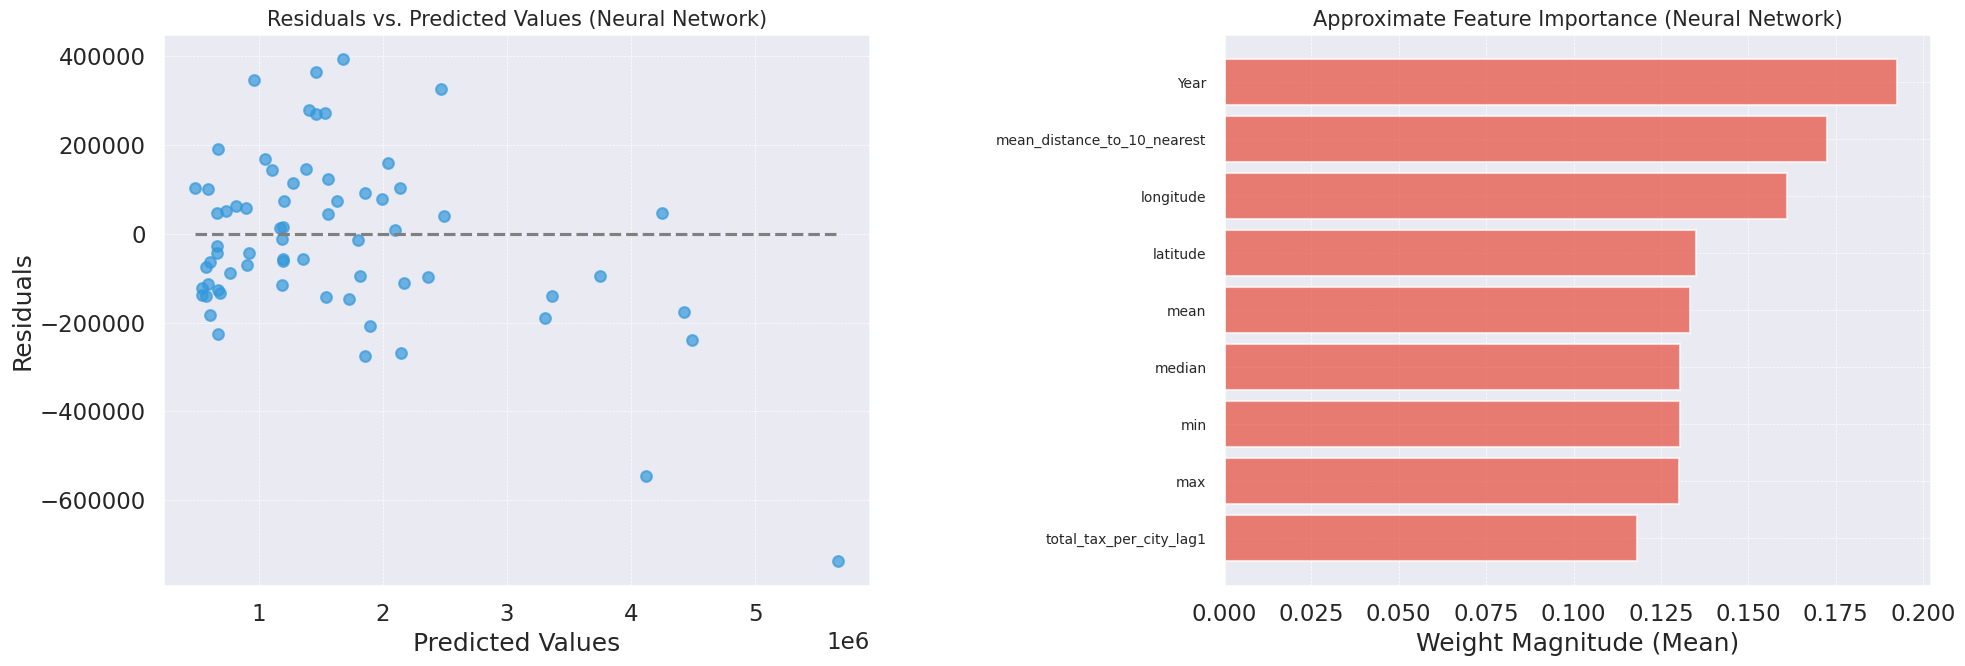

In [27]:
#Making graph
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate residuals for neural network
residuals_nn = y_test - y_pred_nn

# Plot
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

# Residuals vs. Predicted values
ax[0].scatter(y_pred_nn, residuals_nn, color="#3498db", alpha=0.7, s=60)
ax[0].hlines(0, y_pred_nn.min(), y_pred_nn.max(), colors='grey', linestyles='dashed')
ax[0].set_title('Residuals vs. Predicted Values (Neural Network)', fontsize=15)
ax[0].set_xlabel('Predicted Values')
ax[0].set_ylabel('Residuals')
ax[0].grid(True, which='both', linestyle='--', linewidth=0.5)

# Weights of the first layer as an indication of feature importance
# (This is an approximation, not a direct measure of feature importance)
weights_first_layer = model.layers[0].get_weights()[0]
weights_first_layer_mean = np.mean(np.abs(weights_first_layer), axis=1)
sorted_idx_nn = np.argsort(weights_first_layer_mean)

# Ensure we have the feature names
try:
    feature_names = X.columns
except:
    feature_names = [f"Feature {i}" for i in range(weights_first_layer_mean.shape[0])]

ax[1].barh(np.array(feature_names)[sorted_idx_nn], weights_first_layer_mean[sorted_idx_nn], color="#e74c3c", alpha=0.7)
ax[1].set_xlabel('Weight Magnitude (Mean)')
ax[1].set_title('Approximate Feature Importance (Neural Network)', fontsize=15)
ax[1].tick_params(axis='y', labelsize=10)
ax[1].grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.subplots_adjust(wspace=0.5)
plt.show()


# Selecting the Best Model and Training on All Data to Predict the Next Three Years (Using Generative AI)

In this section, we leverage Chat GPT's Generative AI through its API to analyze the DataFrame containing results from all the models. Chat GPT assumes the role of an expert data scientist, not just comparing metrics against each other, but also applying the nuanced judgment typical of an experienced data scientist.


In [28]:
# Reading API Configuration Keys in Private Space

# Read the content from the text file
with open('/content/drive/MyDrive/Godi.AI/Operations/Freelancer/API_Config/Chat_GPT/openai_code.txt', "r") as file:
    content = file.read()

# Extract the organization and api_key values using regex
import re
organization_match = re.search(r'openai.organization = "(.+?)"', content)
api_key_match = re.search(r'openai.api_key = "(.+?)"', content)

organization = organization_match.group(1) if organization_match else None
api_key = api_key_match.group(1) if api_key_match else None


In [29]:
#Installe APEN AI
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 2.6 MB/s eta 0:00:00


In [30]:
# Using generative AI to analyze results
import os
import openai
import re

openai.organization = organization
openai.api_key = api_key

data_json = results_df.to_json()

message = [
    {"role": "system", "content": "You are an experienced data scientist. After reviewing the provided dataframe, offer a very critical conclusion about which model is the best to put into production. It is essential that the chosen model is robust and performs well on unseen data. Please use the exact model names as they appear in the dataframe when providing your recommendation. Additionally, explain why you have chosen this particular model and why other similar models did not make the cut."},
    {"role": "user", "content": f"Here's the data:\n{data_json}"}
]


response = openai.ChatCompletion.create(
    model="gpt-4",
    max_tokens=1000,
    temperature=1.2,
    messages=message
)

# Extract the model's response
response_json = response
conclusion = response_json['choices'][0]['message']['content']

# Extract the chosen model name from the conclusion
model_names_regex = r"(Linear Regression|Decision Tree \(Adjusted\)|Decision Tree \(Grid Search\)|Random Forest \(Grid Search\)|XGBoost \(Grid Search\)|Optimized Neural Network)"
selected_model_match = re.search(model_names_regex, conclusion)
selected_model = selected_model_match.group(0) if selected_model_match else None

In [31]:
#Displaying results in good format
from IPython.display import display, HTML

# Formatting the output text
model_output = f"<h3>Selected Model:</h3> <b>{selected_model}</b>"
conclusion_output = f"<h3>Explanation:</h3> <p>{conclusion}</p>"
ai_notice = f"<div style='margin-top:20px; color:gray;'><i>This selection and explanation have been generated by GPT-based generative AI based on the tested model results.</i></div>"

# Combining the format and displaying the output
final_output = f"<div style='border:1px solid black; padding:10px;'>{model_output}{conclusion_output}{ai_notice}</div>"
display(HTML(final_output))


In [32]:
results_df

,Model,Avg_MSE_CV,Std_MSE_CV,Avg_R2_CV,Std_R2_CV,Avg_MAE_CV,Std_MAE_CV,MSE_Train,R2_Train,MAE_Train,MSE_Test,R2_Test,MAE_Test
0,Linear Regression,3.396769e+10,3.488303e+10,0.965690,0.036130,108121.379692,40052.207152,2.681235e+10,0.977972,99475.826118,1.976297e+10,0.981928,97295.236877
1,Decision Tree (Adjusted),4.599743e+10,2.370902e+10,0.951800,0.032455,135264.444516,42191.764484,2.225299e+10,0.981718,88294.733716,2.944407e+10,0.973075,127826.280935
2,Decision Tree (Grid Search),4.153564e+10,1.419011e+10,0.952009,0.029078,125732.647132,26087.765292,1.290613e+10,0.989397,76632.178770,3.640696e+10,0.966708,128489.895592
3,Random Forest (Grid Search),3.467819e+10,2.615683e+10,0.964818,0.030461,115693.484900,34571.647542,9.754423e+09,0.991986,59379.894739,2.745628e+10,0.974893,119176.672555
4,XGBoost (Grid Search),2.959361e+10,2.218329e+10,0.968016,0.033418,108269.832350,31976.810590,6.438436e+09,0.994711,56955.089286,3.350540e+10,0.969361,118415.753265
5,Optimized Neural Network,7.907334e+10,1.249736e+11,0.936029,0.055645,172605.508770,111733.270762,2.759776e+10,0.977327,117661.093280,3.686540e+10,0.966289,144544.755597


In [33]:
#Graph representation for all model results
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px


df = results_df

# Create a color column for highlighting 'XGBoost (Grid Search)'
df['color'] = df['Model'].apply(lambda x: 1 if x == 'XGBoost (Grid Search)' else 0)

# Parallel Coordinates Plot
fig = px.parallel_coordinates(df, color="color",
                              dimensions=['Avg_MSE_CV', 'Std_MSE_CV', 'Avg_R2_CV', 'Std_R2_CV',
                                          'Avg_MAE_CV', 'Std_MAE_CV', 'MSE_Train', 'R2_Train',
                                          'MAE_Train', 'MSE_Test', 'R2_Test', 'MAE_Test'],
                              color_continuous_scale=["gray", "red"],
                              labels={"color": "Model XGBoost (Grid Search)"})

# Show the plot
fig.show()

In [34]:
#Graph representation for all model results (different color for each model)

df = results_df

# Creamos una columna con colores únicos para cada modelo en el DataFrame
unique_models = df['Model'].unique()
color_mapping = {model: idx for idx, model in enumerate(unique_models)}
df['color'] = df['Model'].apply(lambda x: color_mapping[x])

# Parallel Coordinates Plot
fig = px.parallel_coordinates(df, color="color",
                              dimensions=['Avg_MSE_CV', 'Std_MSE_CV', 'Avg_R2_CV', 'Std_R2_CV',
                                          'Avg_MAE_CV', 'Std_MAE_CV', 'MSE_Train', 'R2_Train',
                                          'MAE_Train', 'MSE_Test', 'R2_Test', 'MAE_Test'],
                              color_continuous_scale=px.colors.qualitative.Set1,  # Escala de colores
                              labels={"color": "Model"})

# Ajustamos la barra de colores para que muestre el nombre del modelo
colorbar = fig.layout.coloraxis.colorbar
colorbar.tickvals = list(color_mapping.values())
colorbar.ticktext = list(color_mapping.keys())

# Show the plot
fig.show()


In [36]:
best_xgb.get_params()


{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.4,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 0,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.05,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 3,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 250,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.5,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}